In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load datasets
train = pd.read_csv("train.csv", parse_dates=['date'])
val = pd.read_csv("val.csv", parse_dates=['date'])
test = pd.read_csv("test.csv", parse_dates=['date'])

# Ensure sorted
train = train.sort_values("date")
val = val.sort_values("date")
test = test.sort_values("date")

print("Regions:", train['Region'].unique())

Regions: ['East US' 'West US' 'North Europe' 'Southeast Asia']


In [3]:
def evaluate_arima(train_series, val_series, order=(5,1,0)):
    model = ARIMA(train_series, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(val_series))

    mae = mean_absolute_error(val_series, forecast)
    rmse = np.sqrt(mean_squared_error(val_series, forecast))
    mape = np.mean(np.abs((val_series - forecast) / val_series)) * 100

    return mae, rmse, mape, forecast


In [6]:
# Train ARIMA per region
for Region in train['Region'].unique():
    print(f"\n🔹 Training ARIMA for region: {Region}")

    train_series = train[train['Region']==Region].groupby('date')['usage_cpu'].mean()
    val_series = val[val['Region']==Region].groupby('date')['usage_cpu'].mean()

    try:
        mae, rmse, mape, forecast = evaluate_arima(train_series, val_series, order=(5,1,0))

        results.append({
            "Model": "ARIMA",
            "Region": Region,
            "MAE": round(mae,2),
            "RMSE": round(rmse,2),
            "MAPE": f"{mape:.2f}%"
        })

    except Exception as e:
        print(f"ARIMA success for {Region}: {e}")


🔹 Training ARIMA for region: East US
ARIMA success for East US: name 'results' is not defined

🔹 Training ARIMA for region: West US
ARIMA success for West US: name 'results' is not defined

🔹 Training ARIMA for region: North Europe
ARIMA success for North Europe: name 'results' is not defined

🔹 Training ARIMA for region: Southeast Asia
ARIMA success for Southeast Asia: name 'results' is not defined



🔮 Final Test Forecast for region: East US


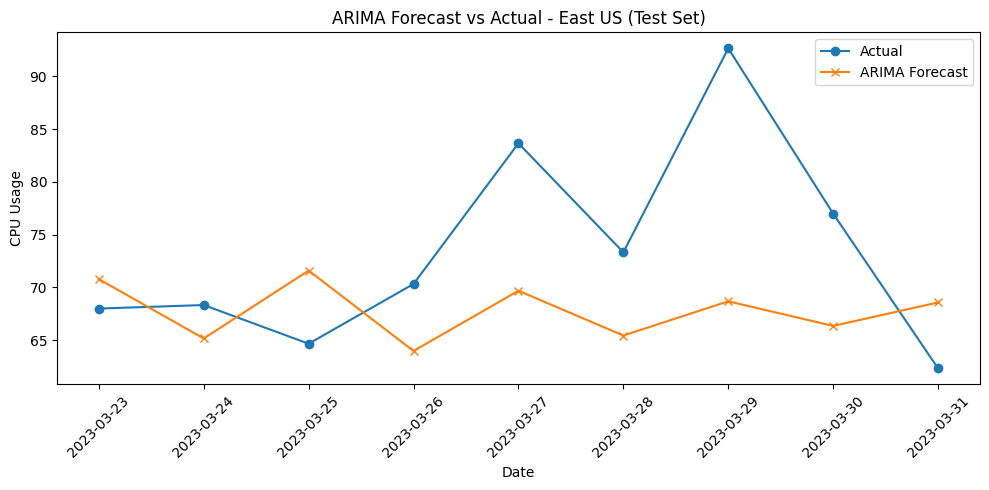


🔮 Final Test Forecast for region: West US


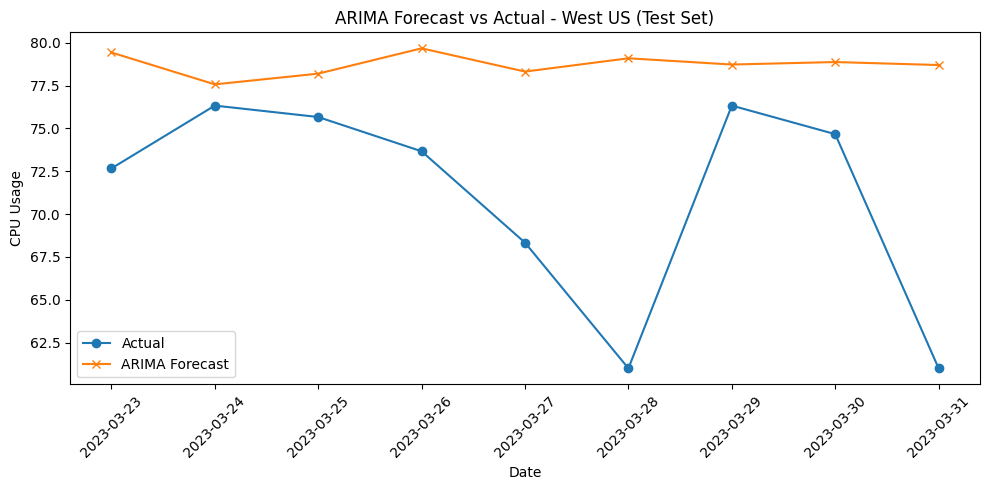


🔮 Final Test Forecast for region: North Europe


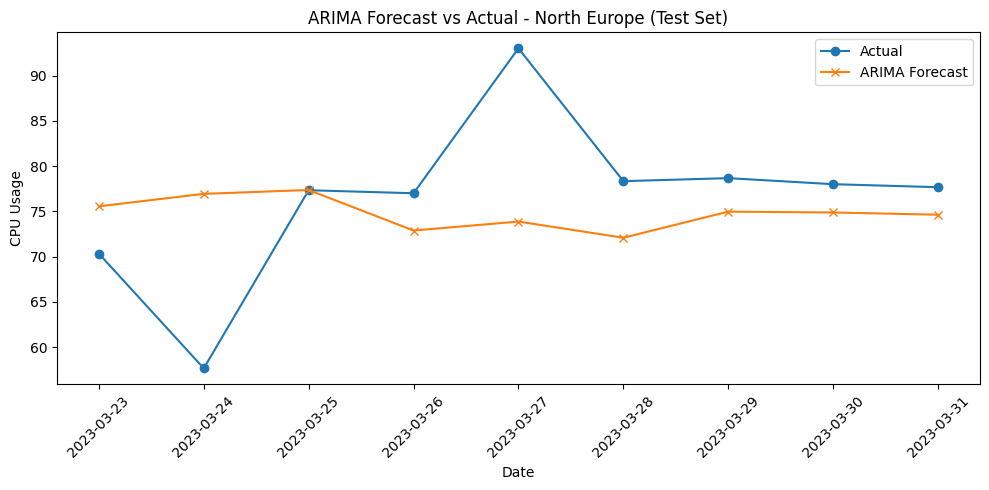


🔮 Final Test Forecast for region: Southeast Asia


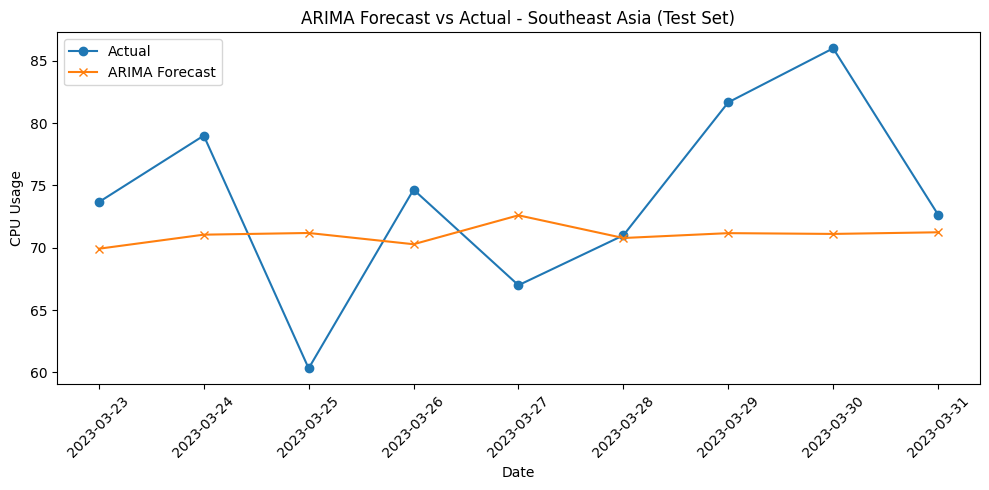


✅ Final Test Forecast Completed!
   Model          Region   MAE   RMSE    MAPE
0  ARIMA         East US  9.11  11.01  11.74%
1  ARIMA         West US  7.66   9.74  11.61%
2  ARIMA    North Europe  7.10   9.73   9.71%
3  ARIMA  Southeast Asia  6.62   8.02   8.86%


In [5]:
# -------------------------------
# Final Test Forecast per Region
# -------------------------------
test_results = []

for Region in train['Region'].unique():
    print(f"\n🔮 Final Test Forecast for region: {Region}")

    # Combine train + val
    train_val_series = pd.concat([
        train[train['Region']==Region],
        val[val['Region']==Region]
    ]).groupby('date')['usage_cpu'].mean()

    test_series = test[test['Region']==Region].groupby('date')['usage_cpu'].mean()

    try:
        model = ARIMA(train_val_series, order=(5,1,0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test_series))

        # Metrics
        mae = mean_absolute_error(test_series, forecast)
        rmse = np.sqrt(mean_squared_error(test_series, forecast))
        mape = np.mean(np.abs((test_series - forecast) / test_series)) * 100

        test_results.append({
            "Model": "ARIMA",
            "Region": Region,
            "MAE": round(mae,2),
            "RMSE": round(rmse,2),
            "MAPE": f"{mape:.2f}%"
        })

        # Plot
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10,5))
        plt.plot(test_series.index, test_series.values, label="Actual", marker='o')
        plt.plot(test_series.index, forecast.values, label="ARIMA Forecast", marker='x')
        plt.title(f"ARIMA Forecast vs Actual - {Region} (Test Set)")
        plt.xlabel("Date")
        plt.ylabel("CPU Usage")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Test forecast failed for {Region}: {e}")

# Save test metrics
df_test_results = pd.DataFrame(test_results)
df_test_results.to_csv("metrics_arima_test.csv", index=False)

print("\n✅ Final Test Forecast Completed!")
print(df_test_results)
